In [545]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.pylabtools import figsize
from pdf2image import convert_from_path
import pytesseract
import pandas as pd
import base64
from io import BytesIO, StringIO
from IPython.display import HTML, display

In [546]:
def show(img, figsize=(12, 9)):
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

Height: 2339, Width: 1654, Area: 3868706


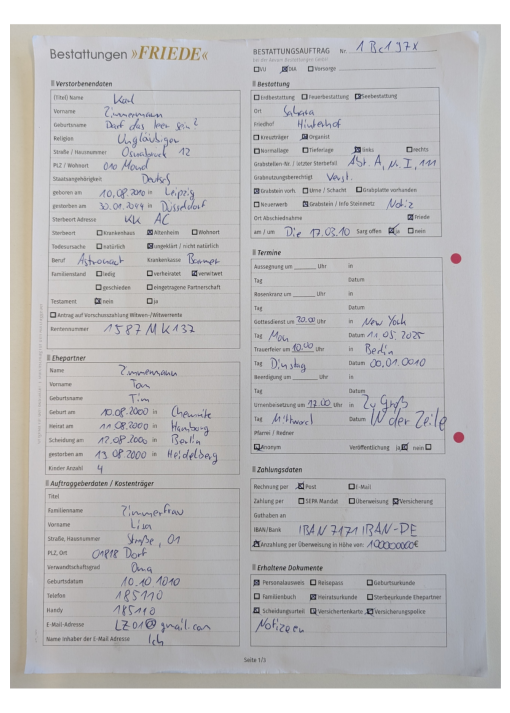

In [547]:
# Load the image
pages = convert_from_path("./testdaten/002.pdf")
page = pages[0]

image = cv2.cvtColor(np.array(pages[0]), cv2.COLOR_RGB2BGR)

image_height = image.shape[0]
image_width = image.shape[1]
image_area = image_height * image_width

print(f"Height: {image_height}, Width: {image_width}, Area: {image_area}")

show(image)

# Document Scan

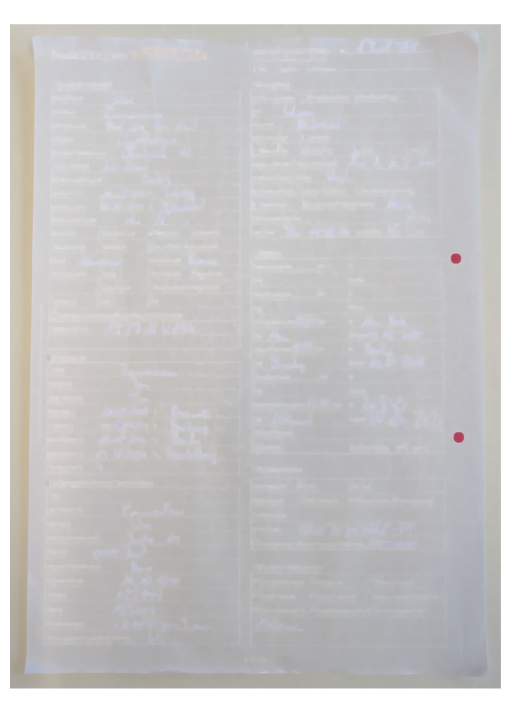

In [548]:
# Repeated Closing operation to remove text from the document.
kernel = np.ones((5,5),np.uint8)
without_text = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations= 3)

show(without_text)

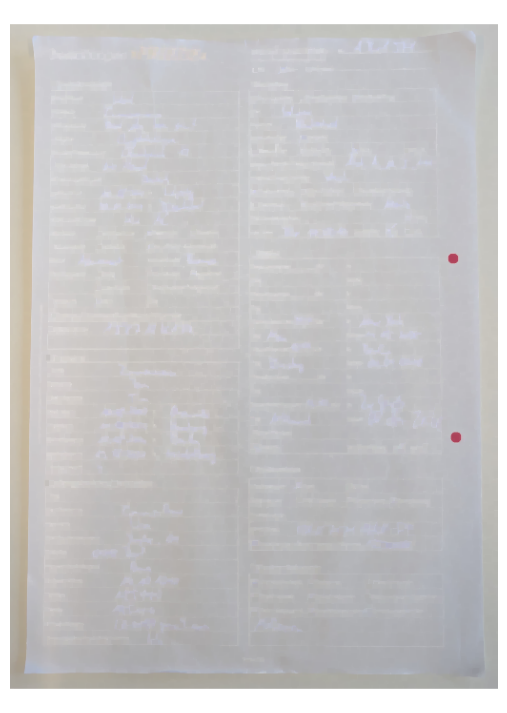

In [549]:
resized = cv2.resize(without_text, (512, 728))
mask = np.zeros(resized.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)


show(resized)

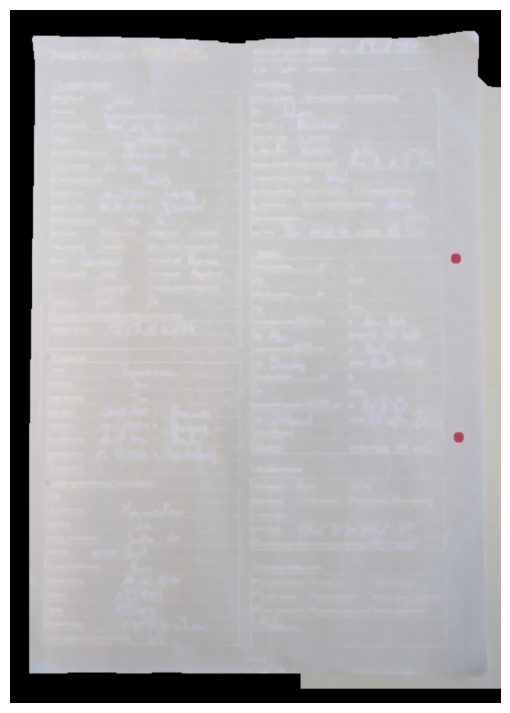

In [550]:
rect = (20,20,resized.shape[1]-20,resized.shape[0]-20)
cv2.grabCut(resized,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
scanned = cv2.resize(resized*mask2[:,:,np.newaxis], (image_width, image_height))
show(scanned)

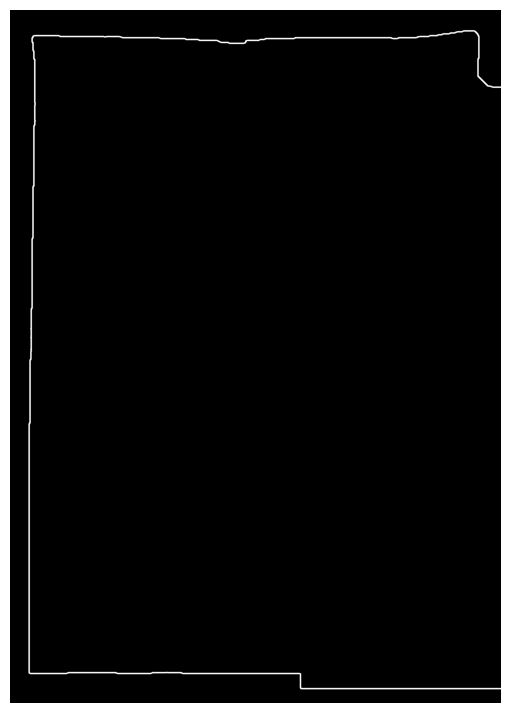

In [551]:
gray = cv2.cvtColor(scanned, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (11, 11), 0)
# Edge Detection.
canny = cv2.Canny(gray, 0, 200)
canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
show(canny)

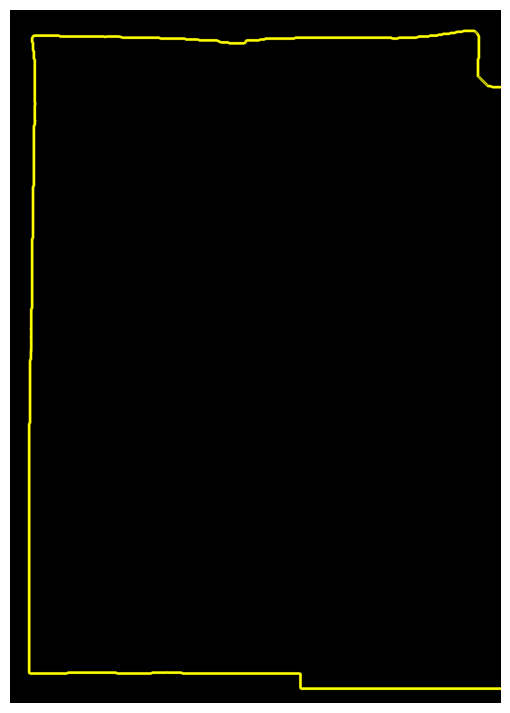

In [552]:
# Blank canvas.
con = np.zeros_like(image)
# Finding contours for the detected edges.
contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
# Keeping only the largest detected contour.
page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
con = cv2.drawContours(con, page, -1, (0, 255, 255), 3)
show(con)

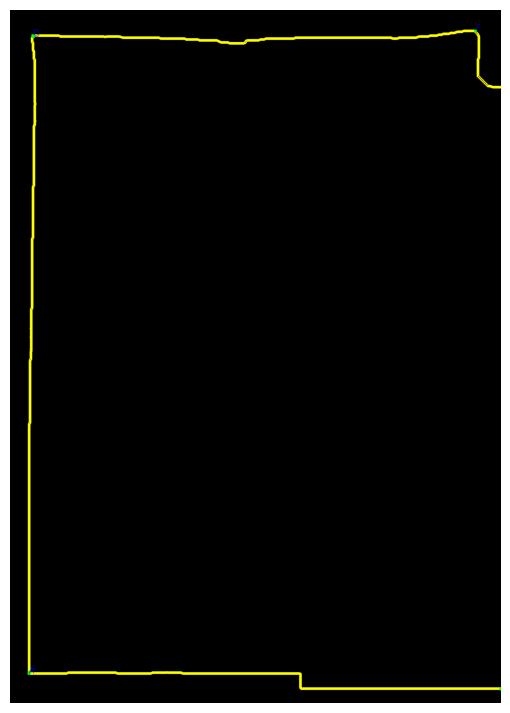

In [553]:
# Blank canvas.
con = np.zeros_like(image)
# Loop over the contours.
for c in page:
    # Approximate the contour.
    epsilon = 0.02 * cv2.arcLength(c, True)
    corners = cv2.approxPolyDP(c, epsilon, True)
    # If our approximated contour has four points
    if len(corners) == 4:
        break
cv2.drawContours(con, c, -1, (0, 255, 255), 3)
cv2.drawContours(con, corners, -1, (0, 255, 0), 10)
# Sorting the corners and converting them to desired shape.
corners = sorted(np.concatenate(corners).tolist())

# Displaying the corners.
for index, c in enumerate(corners):
    character = chr(65 + index)
    cv2.putText(con, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1, cv2.LINE_AA)

show(con)

In [554]:
def order_points(pts):
    '''Rearrange coordinates to order:
      top-left, top-right, bottom-right, bottom-left'''
    rect = np.zeros((4, 2), dtype='float32')
    pts = np.array(pts)
    s = pts.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference.
    rect[1] = pts[np.argmin(diff)]
    # Bottom-left will have the largest difference.
    rect[3] = pts[np.argmax(diff)]
    # Return the ordered coordinates.
    return rect.astype('int').tolist()

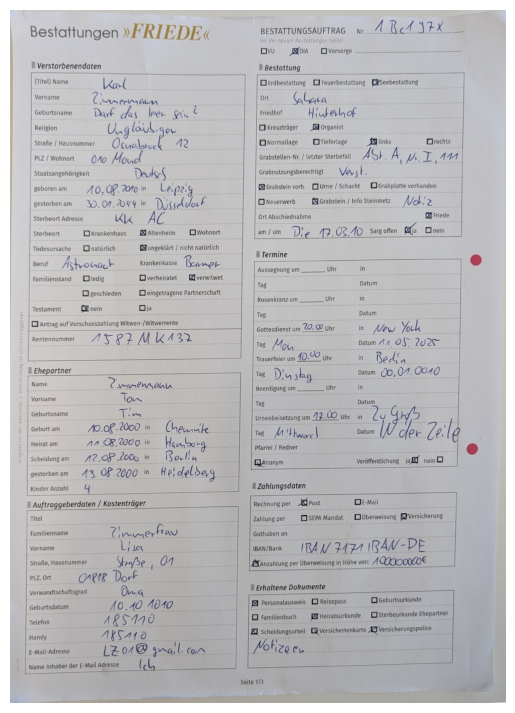

In [555]:
def perspective_transform(image, corners):
    if len(corners) < 4:
        print("Could not find enough corners. Returning original image.")
        return image

    (tl, tr, br, bl) = order_points(corners)
    # Finding the maximum width.
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # Finding the maximum height.
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # Final destination co-ordinates.
    destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]

    destination_corners_contour = np.array(destination_corners).reshape((-1,1,2)).astype(np.int32)
    area = cv2.contourArea(destination_corners_contour)

    if area / image_area < 0.7:
        print("Transformed image would be too small. Returning original image.")
        return image

    # Getting the homography.
    M = cv2.getPerspectiveTransform(np.float32((tl, tr, br, bl)), np.float32(destination_corners))
    # Perspective transform using homography.
    return cv2.warpPerspective(image, M, (destination_corners[2][0], destination_corners[2][1]), flags=cv2.INTER_LINEAR)

image = perspective_transform(image, corners)
show(image)

# Layout Parsing

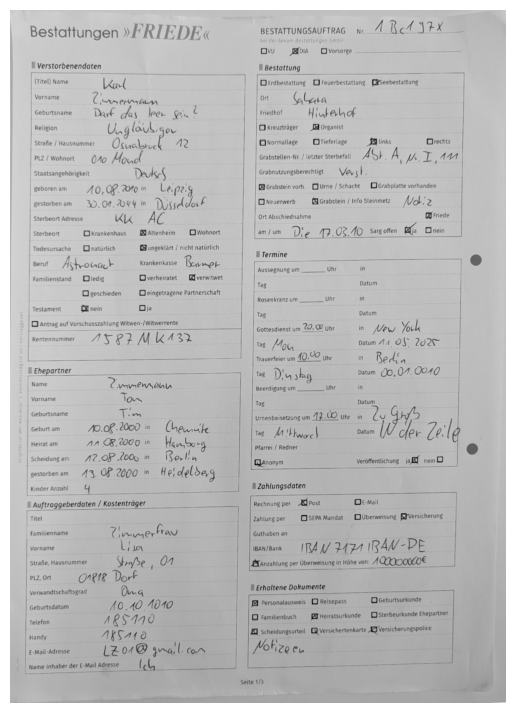

In [556]:
gray = cv2.medianBlur(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), 3)
show(gray)

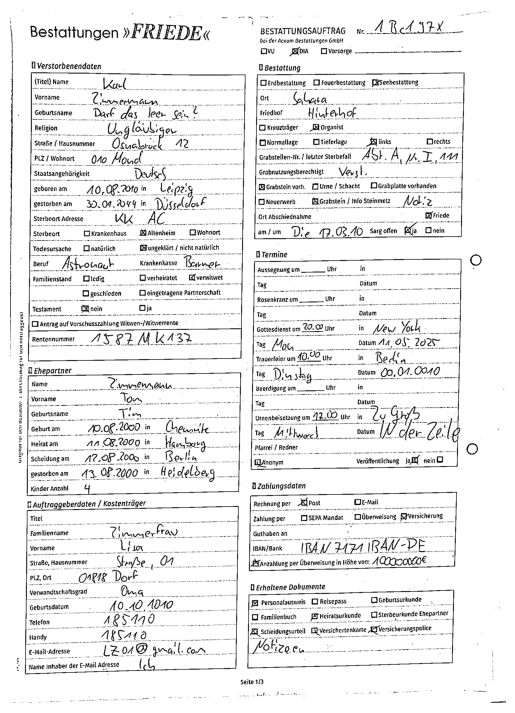

In [557]:
# Thresholding the image
img_bin = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 5)
show(img_bin)

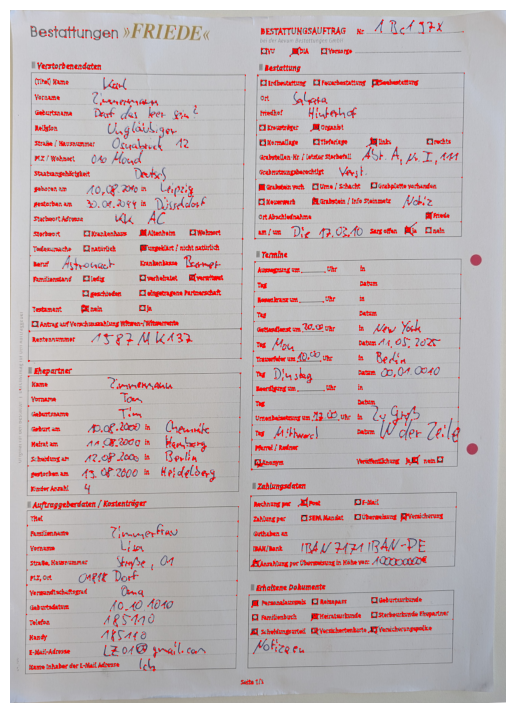

In [558]:
corners = cv2.cornerHarris(gray,2,3,0.04)

#result is dilated for marking the corners, not important
corners = cv2.dilate(corners,None)

# Threshold for an optimal value, it may vary depending on the image.
img_corners = image.copy()
img_corners[corners>0.01*corners.max()]=[0,0,255]

show(img_corners)


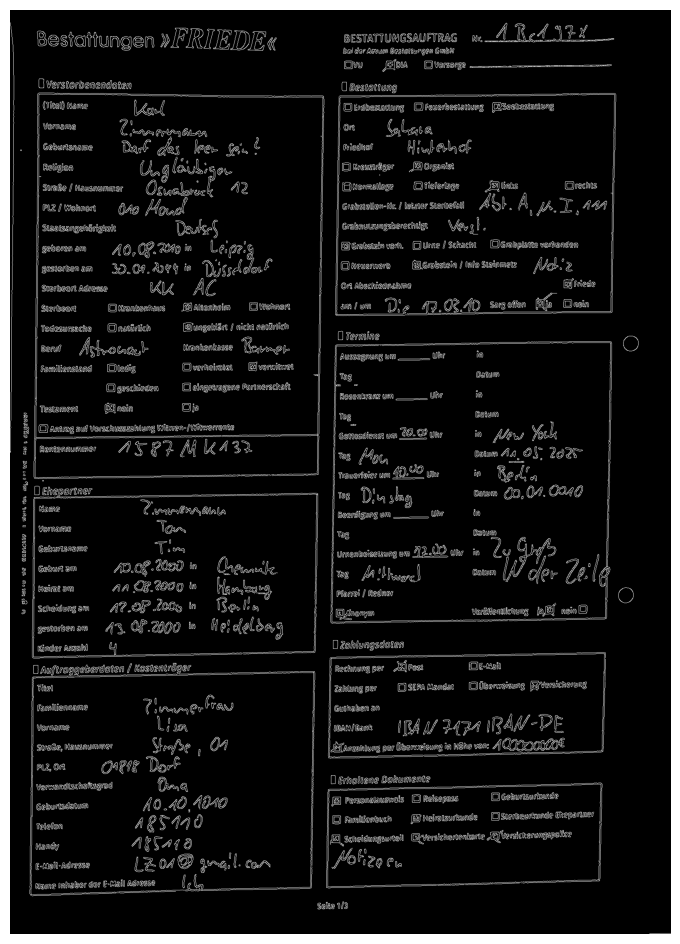

In [559]:
edges = cv2.Canny(gray, 50, 150, apertureSize=3)
# Apply dilation to make edges thicker# Define a kernel
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))

# Dilation and Erosion
# edges = cv2.dilate(edges, kernel, iterations=1)
# edges = cv2.erode(edges, kernel, iterations=1)

show(edges, figsize=(21, 12))


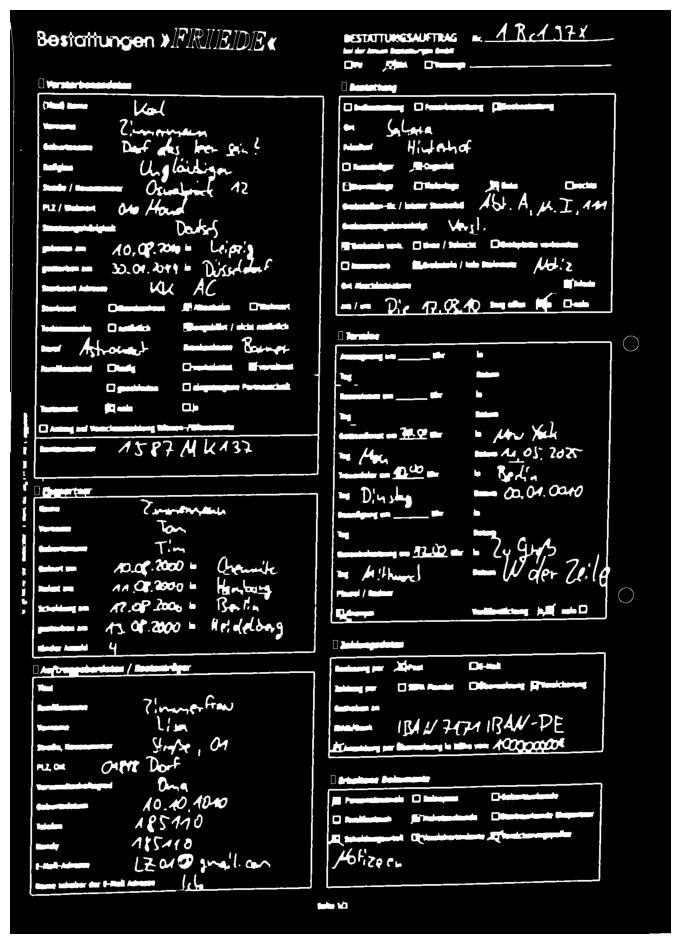

In [560]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
morph = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=1)

show(morph, figsize=(21, 12))

0.0
0.0
0.0
0.0
0.0
0.0
90.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
90.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
90.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
90.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
90.0
0.0
90.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
90.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
90.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


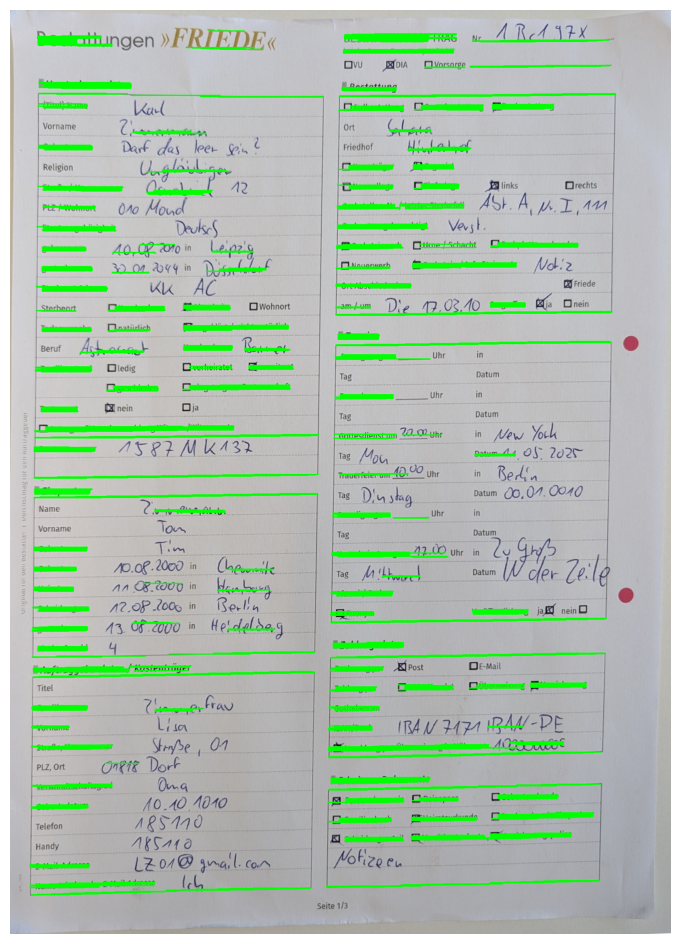

In [561]:
# Use canny edge detection
lines = cv2.HoughLinesP(
    morph, # Input edge image
    0.1, # Distance resolution in pixels
    np.pi/180, # Angle resolution in radians
    threshold=30, # Min number of votes for valid line
    minLineLength=image_width*0.05, # Min allowed length of line
    maxLineGap=10 # Max allowed gap between line for joining them
)

line_img = image.copy()
horiz_lines = []
vert_lines = []

for line in lines:
    x1, y1, x2, y2 = line[0]
    angle = np.abs(np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi)  # Calculate angle
    print(angle)
    if angle < 10:  # Example: nearly horizontal lines
        horiz_lines.append((np.array([x1, y1]), np.array([x2, y2])))
    if 70 < angle < 110:  # Example: nearly horizontal lines
        vert_lines.append((np.array([x1, y1]), np.array([x2, y2])))

def merge_lines(lines, threshold=10):
    merged = []
    for line in lines:
        p1, p2 = line
        for merged_line in merged:
            mp1, mp2 = merged_line
            denominator = np.linalg.norm(p2 - p1)
            numerator1 = np.abs(np.cross(p2 - p1, p1 - mp1))
            numerator2 = np.abs(np.cross(p2 - p1, p1 - mp2))
            d1 = numerator1 / denominator
            d2 = numerator2 / denominator

            if d1 < threshold or d2 < threshold:
                mp1[0] = min(p1[0], mp1[0])
                mp1[1] = min(p1[1], mp1[1])
                mp2[0] = max(p2[0], mp2[0])
                mp2[1] = max(p2[1], mp2[1])
                break
        else:
            merged.append(line)
    return merged

def filter_lines_length(lines, min, max):
    filtered = []
    for line in lines:
        p1, p2 = line
        length = np.linalg.norm(p1 - p2)
        if min < length < max:
            filtered.append(line)
    return filtered

#horiz_lines = merge_lines(horiz_lines, threshold=1)
# horiz_lines = filter_lines_length(horiz_lines, min=0.3*image_width, max=0.5*image_width)
# vert_lines = merge_lines(vert_lines, threshold=10)

# Iterate over points
for points in horiz_lines:
    # Extracted points nested in the list
    p1, p2 = points

    # Draw the lines joining the points
    # On the original image
    cv2.line(line_img,p1,p2,(0,255,0),2)

show(line_img, figsize=(21,12))

In [610]:
# TODO: Eventuell corner detection noch ansehen

# Find contours in the binary image
contours, hierarchy = cv2.findContours(~img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw rectangles around each contour
img_groups = image.copy()
target_rois = []

rects = map(cv2.boundingRect, contours)
rects = [(x, y, w, h) for (x, y, w, h) in rects if not (w / image_width < 0.3 or w / image_width > 0.5)]
rects = sorted(rects, key=lambda x: x[0])

rects_left = sorted(rects[:3], key=lambda x: x[1])
rects_right = sorted(rects[3:], key=lambda x: x[1])

data = pd.DataFrame({
    "Verstorbenendaten": rects_left[0],
    "Ehepartner": rects_left[1],
    "Auftraggeberdaten": rects_left[2],
    "Bestattung": rects_right[0],
    "Termine": rects_right[1],
    "Zahlungsdaten": rects_right[2],
    "Erhaltene Dokumente": rects_right[3]
})
data

Verstorbenendaten  Ehepartner  Auftraggeberdaten  Bestattung  Termine  \
0                 58          54                 48         783      772   
1                200        1152               1591         201      798   
2                697         687                685         674      675   
3                927         407                540         534      677   

   Zahlungsdaten  Erhaltene Dokumente  
0            766                  761  
1           1546                 1860  
2            667                  663  
3            254                  252

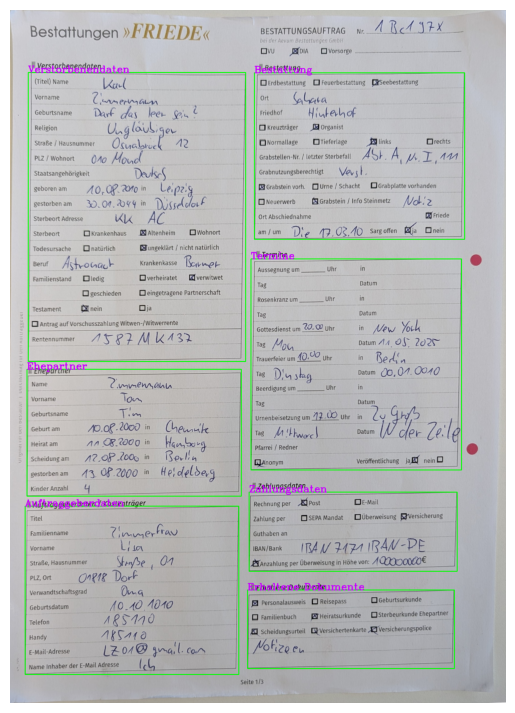

In [611]:
for key, (x, y, w, h) in data.items():
    cv2.rectangle(img_groups, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(img_groups, key, (x, y), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 0, 200), 2)

show(img_groups)

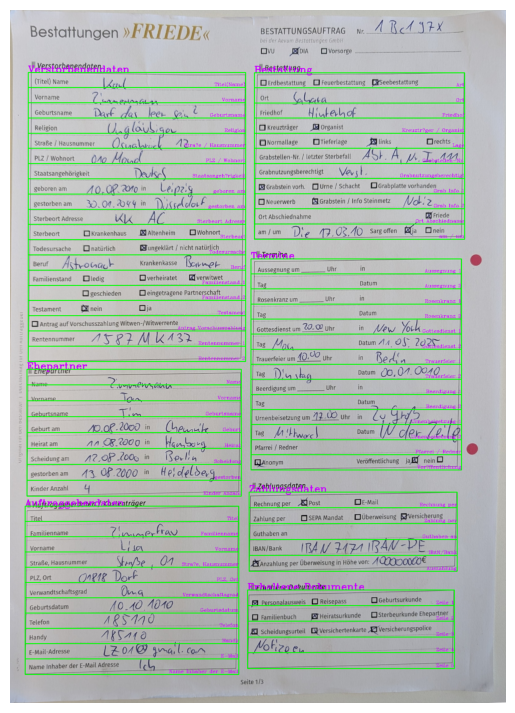

group                field  \
group_index field_index                                             
0           0              Verstorbenendaten          Titel(Name)   
            1              Verstorbenendaten              Vorname   
            2              Verstorbenendaten          Geburtsname   
            3              Verstorbenendaten             Religion   
            4              Verstorbenendaten  Straße / Hausnummer   
...                                      ...                  ...   
6           0            Erhaltene Dokumente              Zeile 1   
            1            Erhaltene Dokumente              Zeile 2   
            2            Erhaltene Dokumente              Zeile 3   
            3            Erhaltene Dokumente              Zeile 4   
            4            Erhaltene Dokumente              Zeile 5   

                                              points  \
group_index field_index                                
0           0                [[58, 200], [755, 248]]   
            1                [[58, 248], [755, 297]]   
            2                [[58, 297], [755, 346]]   
            3                [[58, 346], [755, 395]]   
            4                [[58, 395], [755, 443]]   
...                                              ...   
6           0            [[761, 1860], [1424, 1910]]   
            1            [[761, 1910], [1424, 1960]]   
            2            [[761, 1960], [1424, 2011]]   
            3            [[761, 2011], [1424, 2061]]   
            4            [[761, 2061], [1424, 2112]]   

                                                                       img  
group_index field_index                                                     
0           0            b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...  
            1            b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...  
            2            b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...  
            3            b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...  
            4            b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...  
...                                                                    ...  
6           0            b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...  
            1            b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...  
            2            b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...  
            3            b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...  
            4            b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...  

[73 rows x 4 columns]

In [648]:
groups = pd.read_csv('groups.csv', index_col=["group_index", "field_index"])
img_fields = img_groups.copy()

def get_points(row):
    group_name = row["group"]
    field_index = row.name[1]
    (x, y, w, h) = data[group_name]

    parts = len(groups[groups.group == group_name])
    part_size = h / parts
    part_start_y = part_size * field_index

    return [
        np.array([x, y + part_start_y]).astype(np.int32),
        np.array([x + w, y + part_start_y + part_size]).astype(np.int32)
    ]

def get_img(row):
    [point1, point2] = row["points"]
    image_part = image[point1[1]:point2[1], point1[0]:point2[0]].copy()
    img_encode = cv2.imencode('.png', image_part)[1]
    return img_encode.tobytes()

groups["points"] = groups.apply(get_points, axis=1)
groups["img"] = groups.apply(get_img, axis=1)

for _, row in groups.iterrows():
    field_name = row["field"]
    [point1, point2] = row["points"]

    cv2.rectangle(
        img_fields,
        point1,
        point2,
        (0, 255, 0),
        2)
    font = cv2.FONT_HERSHEY_COMPLEX
    font_size = 0.5
    font_thickness = 1
    ([text_width, _], text_height) = cv2.getTextSize(field_name, font, font_size, font_thickness)
    cv2.putText(img_fields, field_name, np.array([point2[0] - text_width, point2[1] - text_height]).astype(np.int32), font, font_size, (255, 0, 200), font_thickness)

show(img_fields)
groups